# *Monod* model selection: fit to liver cell types

In the current notebook, we run the *Monod* inference pipeline on two pre-clustered human liver datasets, disaggregated into pericentral, periportal, and interzonal hepatocytes, using a common set of 3,000 genes and four models (bursty, extrinsic, delayed-splicing, and delayed-efflux).

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [69]:
dataset_meta = ['liver_c72_'+x for x in ['sc','sn']]

cluster_names = ['CentralHep','PortalHep','InterHep']
dataset_names = [x+'_'+y for x in dataset_meta for y in cluster_names]  
raw_data_locations = [x for x in dataset_meta for y in cluster_names]
# dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names]

transcriptome_filepath = '../polyA_ref/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]


loom_filepaths = ['/home/ggorin/count_data/loom_liver_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)




In [26]:
# loom_filepaths = ['/home/ggorin/count_data/loom_liver_kb/liver_c72_'+dataset_meta[0]+'.loom' ]*len(cluster_names) + \
#                  ['/home/ggorin/count_data/loom_liver_kb/liver_c72_'+dataset_meta[1]+'.loom' ]*len(cluster_names) 


In [27]:
loom_filepaths

['/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom',
 '/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom']

In [28]:
n_datasets = len(loom_filepaths)

## Filtering

### Import metadata

In [29]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

In [30]:
meta_str = '/home/ggorin/datasets/liver_andrews/GSE185477_Final_Metadata.txt'
meta = pd.read_csv(meta_str,sep='\t')

In [31]:
meta

orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
C41_AAACCTGAGCCTTGAT              C41         428           199   32.087912   
C41_AAACCTGAGGTCATCT              C41         275           181   19.666667   
C41_AAACCTGAGTCGCCGT              C41         632           264   15.703704   
C41_AAACCTGAGTGGAGTC              C41       10508          1923   12.188988   
C41_AAACCTGAGTTAACGA              C41         503           220   26.355140   
...                               ...         ...           ...         ...   
C72_RESEQ_TTTGTCATCCGTAGGC  C72_RESEQ        1101           520   14.613424   
C72_RESEQ_TTTGTCATCGCATGGC  C72_RESEQ         834           468   12.542373   
C72_RESEQ_TTTGTCATCGCCTGTT  C72_RESEQ        3245          1322    8.756418   
C72_RESEQ_TTTGTCATCTGATTCT  C72_RESEQ        1651           648   31.873905   
C72_RESEQ_TTTGTCATCTTTCCTC  C72_RESEQ        1022           471   12.371134   

                                cell_barcode donor  \
C41_AAACCTGAGCCTTGAT        AAACCTGAGCCTTGAT   C41   
C41_AAACCTGAGGTCATCT        AAACCTGAGGTCATCT   C41   
C41_AAACCTGAGTCGCCGT        AAACCTGAGTCGCCGT   C41   
C41_AAACCTGAGTGGAGTC        AAACCTGAGTGGAGTC   C41   
C41_AAACCTGAGTTAACGA        AAACCTGAGTTAACGA   C41   
...                                      ...   ...   
C72_RESEQ_TTTGTCATCCGTAGGC  TTTGTCATCCGTAGGC   C72   
C72_RESEQ_TTTGTCATCGCATGGC  TTTGTCATCGCATGGC   C72   
C72_RESEQ_TTTGTCATCGCCTGTT  TTTGTCATCGCCTGTT   C72   
C72_RESEQ_TTTGTCATCTGATTCT  TTTGTCATCTGATTCT   C72   
C72_RESEQ_TTTGTCATCTTTCCTC  TTTGTCATCTTTCCTC   C72   

                                               cell_ID   S.Score  G2M.Score  \
C41_AAACCTGAGCCTTGAT              C41_AAACCTGAGCCTTGAT -0.009246  -0.016106   
C41_AAACCTGAGGTCATCT              C41_AAACCTGAGGTCATCT -0.018254  -0.027253   
C41_AAACCTGAGTCGCCGT              C41_AAACCTGAGTCGCCGT -0.010180  -0.027701   
C41_AAACCTGAGTGGAGTC              C41_AAACCTGAGTGGAGTC  0.030654  -0.030400   
C41_AAACCTGAGTTAACGA              C41_AAACCTGAGTTAACGA -0.020764  -0.021055   
...                                                ...       ...        ...   
C72_RESEQ_TTTGTCATCCGTAGGC  C72_RESEQ_TTTGTCATCCGTAGGC  0.027977  -0.028536   
C72_RESEQ_TTTGTCATCGCATGGC  C72_RESEQ_TTTGTCATCGCATGGC -0.012619  -0.020361   
C72_RESEQ_TTTGTCATCGCCTGTT  C72_RESEQ_TTTGTCATCGCCTGTT -0.041129   0.004319   
C72_RESEQ_TTTGTCATCTGATTCT  C72_RESEQ_TTTGTCATCTGATTCT -0.014500  -0.024372   
C72_RESEQ_TTTGTCATCTTTCCTC  C72_RESEQ_TTTGTCATCTTTCCTC -0.008821   0.014429   

                           Phase     sample   assay_type  Coarse_clusters  \
C41_AAACCTGAGCCTTGAT          G1        C41  single_cell               11   
C41_AAACCTGAGGTCATCT          G1        C41  single_cell               10   
C41_AAACCTGAGTCGCCGT          G1        C41  single_cell               13   
C41_AAACCTGAGTGGAGTC           S        C41  single_cell                4   
C41_AAACCTGAGTTAACGA          G1        C41  single_cell                7   
...                          ...        ...          ...              ...   
C72_RESEQ_TTTGTCATCCGTAGGC     S  C72_RESEQ  single_cell                7   
C72_RESEQ_TTTGTCATCGCATGGC    G1  C72_RESEQ  single_cell                2   
C72_RESEQ_TTTGTCATCGCCTGTT   G2M  C72_RESEQ  single_cell                9   
C72_RESEQ_TTTGTCATCTGATTCT    G1  C72_RESEQ  single_cell                0   
C72_RESEQ_TTTGTCATCTTTCCTC   G2M  C72_RESEQ  single_cell                2   

                           Manual_Annotation Subcluster_Group sub_cluster  \
C41_AAACCTGAGCCTTGAT                InterHep       Hepatocyte       Hep_6   
C41_AAACCTGAGGTCATCT                 cvLSECs            LSECs      LSEC_1   
C41_AAACCTGAGTCGCCGT                  Bcells           Bcells     Lymph_5   
C41_AAACCTGAGTGGAGTC                InterHep       Hepatocyte       Hep_4   
C41_AAACCTGAGTTAACGA                 NKTcell          NKTcell     Lymph_0   
...                                      ...              ...         ...   
C72_RESEQ_TTTGTC

/home/ggorin/count_data/loom_liver_kb/liver_c72_sc.loom
Dataset liver_c72_sc. 
	11219 barcodes in loom, 10746 pass filter. 11219 in annotations; of these, 11219 in loom and 10746 in filtered loom.
	CentralHep: 1779 cells in annotations. 1779 in loom. 1567 pass filter.
	PortalHep: 4523 cells in annotations. 4523 in loom. 4421 pass filter.
	InterHep: 1046 cells in annotations. 1046 in loom. 991 pass filter.
/home/ggorin/count_data/loom_liver_kb/liver_c72_sn.loom
Dataset liver_c72_sn. 
	9054 barcodes in loom, 9033 pass filter. 9054 in annotations; of these, 9054 in loom and 9033 in filtered loom.
	CentralHep: 2888 cells in annotations. 2888 in loom. 2885 pass filter.
	PortalHep: 2862 cells in annotations. 2862 in loom. 2862 pass filter.
	InterHep: 1888 cells in annotations. 1888 in loom. 1879 pass filter.


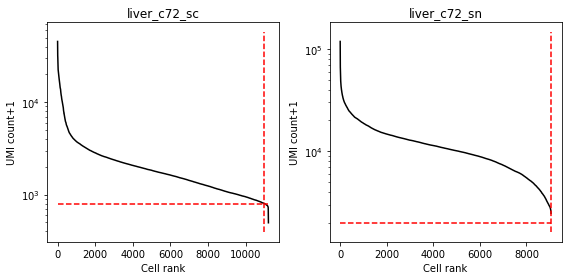

In [41]:
cf = []
thr_lb = [8e2, 2e3]
thr_ub = [1e4, 5e4]
S_arr = []
U_arr = []


fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

dataset_identifiers = ('C72_RESEQ','C72_TST')
for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k]
    dataset_name = dataset_meta[k]
    print(filename)
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k]) & ((S+U).sum(0)<thr_ub[k])
        ax1[k].set_title(dataset_meta[k])        
        n_annot_bcs = (meta['sample']==dataset_identifiers[k]).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_identifiers[k])]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_identifiers[k])]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')

        S_arr.append(S)
        U_arr.append(U)
        for cluster in cluster_names:            
            annot_bcs = meta[(meta['sample']==dataset_identifiers[k]) \
                                       & (meta['Manual_Annotation']==cluster)]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')
fig1.tight_layout()

In [40]:
[x.sum() for x in cf]

[1567, 4421, 991, 2885, 2862, 1879]

## Sc/sn comparison

In [84]:
def plot_stat(X,Y,stat,ax1,modality='spliced',plot_offset=False):
    if stat=='mean':
        stat_fun = lambda x: x.mean(1)
    elif stat=='CV2':
        stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)
    
    x = stat_fun(X)
    y = stat_fun(Y)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1.scatter(x,y,1,'k',alpha=0.3)
    xl = np.linspace(x.min(),x.max())
    ax1.plot(xl,xl,'--',color='crimson',linewidth=4)
    if plot_offset:
        offset = y.mean()/x.mean()
        print('Offset: {:.2f}'.format(np.log10(offset)))
        ax1.plot(xl,xl*offset,color='lightseagreen',linewidth=2)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('single-cell {} {}'.format(stat,modality))
    ax1.set_ylabel('single-nucleus {} {}'.format(stat,modality))

/tmp/ipykernel_436754/1752493799.py:5: RuntimeWarning: invalid value encountered in divide
  stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)


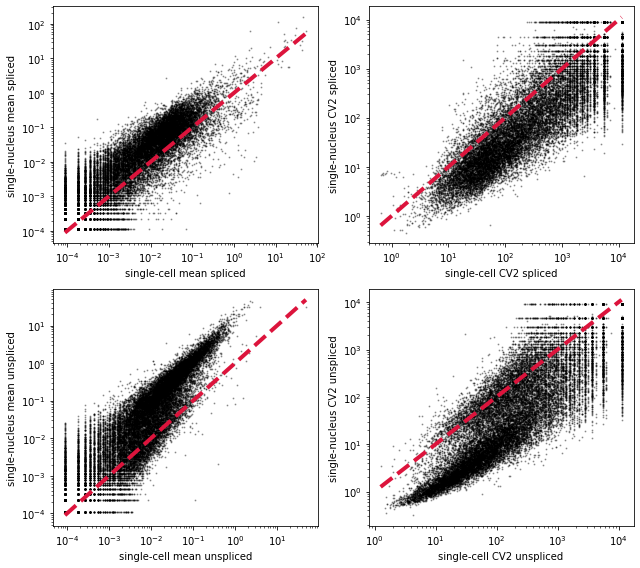

In [55]:
fig1,ax1 = plt.subplots(2,2,figsize=(9,8))

plot_stat(S_arr[0],S_arr[1],'mean',ax1[0][0],'spliced')
plot_stat(S_arr[0],S_arr[1],'CV2',ax1[0][1],'spliced')
plot_stat(U_arr[0],U_arr[1],'mean',ax1[1][0],'unspliced')
plot_stat(U_arr[0],U_arr[1],'CV2',ax1[1][1],'unspliced')
fig1.tight_layout()


/tmp/ipykernel_436754/680583236.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(S_arr[0].mean(1),S_arr[0].var(1)/(S_arr[0].mean(1)**2),3,'k',alpha=0.2)


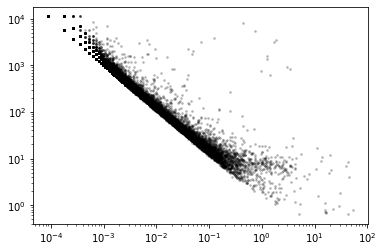

In [65]:
plt.scatter(S_arr[0].mean(1),S_arr[0].var(1)/(S_arr[0].mean(1)**2),3,'k',alpha=0.2)
plt.xscale('log')
plt.yscale('log')

/tmp/ipykernel_436754/2533449854.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(U_arr[0].mean(1),U_arr[0].var(1)/(U_arr[0].mean(1)**2),3,'k',alpha=0.2)


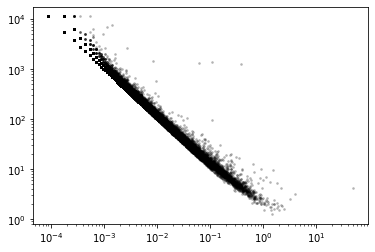

In [77]:
plt.scatter(U_arr[0].mean(1),U_arr[0].var(1)/(U_arr[0].mean(1)**2),3,'k',alpha=0.2)
plt.xscale('log')
plt.yscale('log')

/tmp/ipykernel_436754/1752493799.py:5: RuntimeWarning: invalid value encountered in divide
  stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)


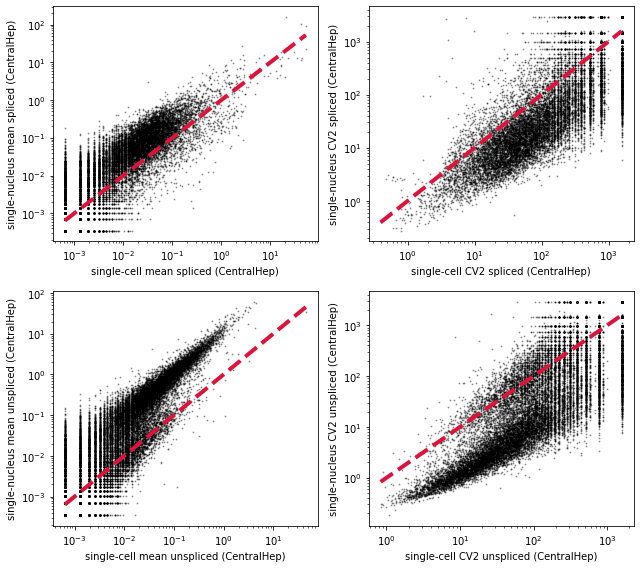

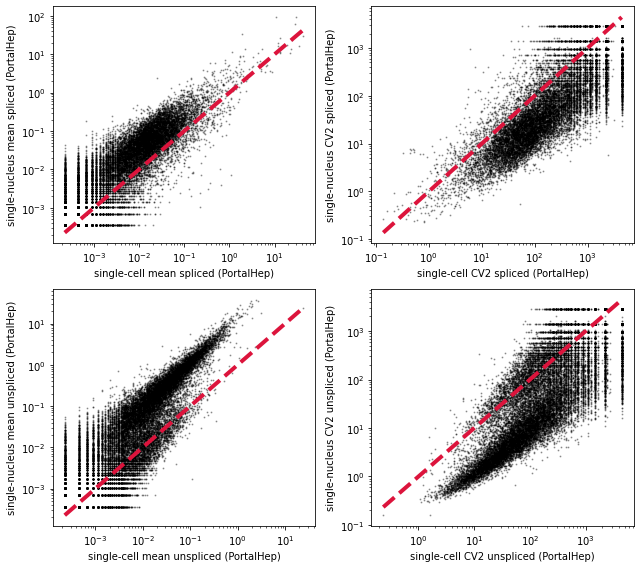

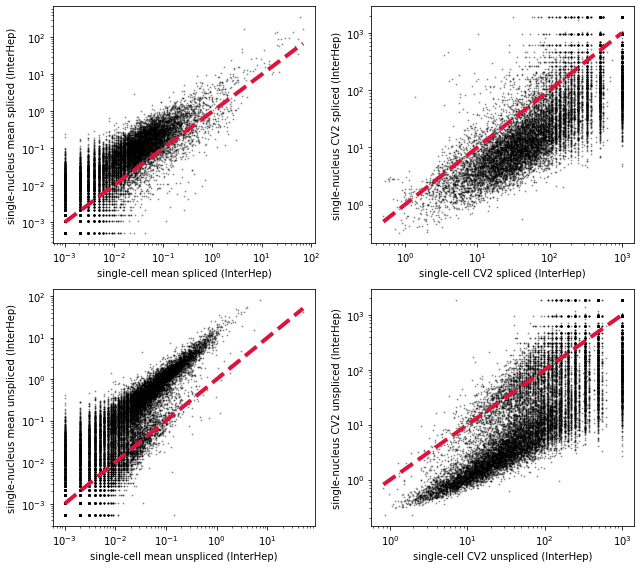

In [62]:
for k in range(3):
    fig1,ax1 = plt.subplots(2,2,figsize=(9,8))
    plot_stat(S_arr[0][:,cf[k]],
              S_arr[1][:,cf[k+len(cluster_names)]],
              'mean',ax1[0][0],'spliced ({})'.format(cluster_names[k]))
    plot_stat(S_arr[0][:,cf[k]],
              S_arr[1][:,cf[k+len(cluster_names)]],
              'CV2',ax1[0][1],'spliced ({})'.format(cluster_names[k]))
    plot_stat(U_arr[0][:,cf[k]],
              U_arr[1][:,cf[k+len(cluster_names)]],
              'mean',ax1[1][0],'unspliced ({})'.format(cluster_names[k]))
    plot_stat(U_arr[0][:,cf[k]],
              U_arr[1][:,cf[k+len(cluster_names)]],
              'CV2',ax1[1][1],'unspliced ({})'.format(cluster_names[k]))
    fig1.tight_layout()


## Preprocessing

Identify the genes to fit.

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

In [70]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [71]:
transcriptome_filepath

'../polyA_ref/gg_200525_genome_polyA_cum_3'

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1 already exists.
INFO:root:Dataset: liver_c72_sc_CentralHep
INFO:root:1567 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:516 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep created.
INFO:root:Dataset: liver_c72_sc_PortalHep
INFO:root:4421 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:539 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep created.
INFO:root:Dataset: liver_c72_sc_InterHep
INFO:root:991 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:393 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1

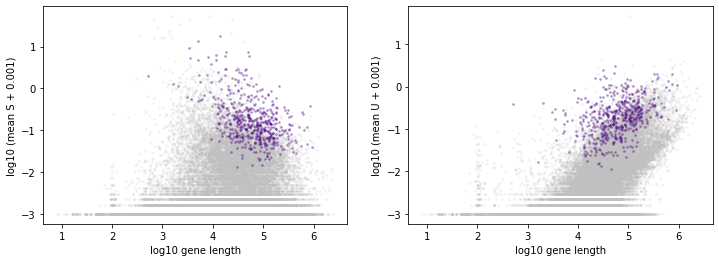

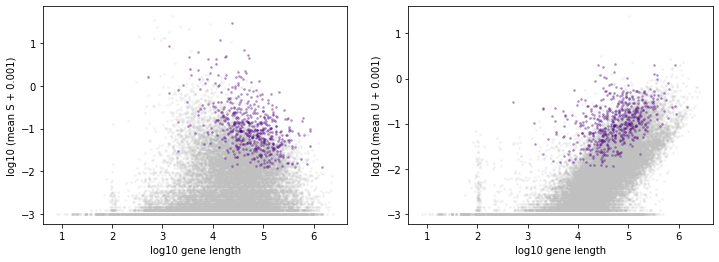

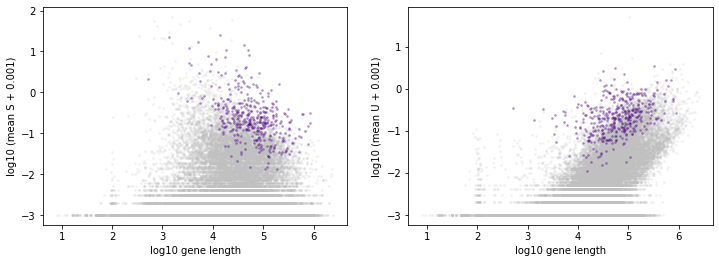

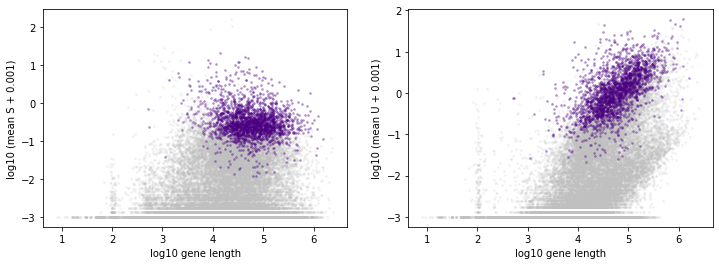

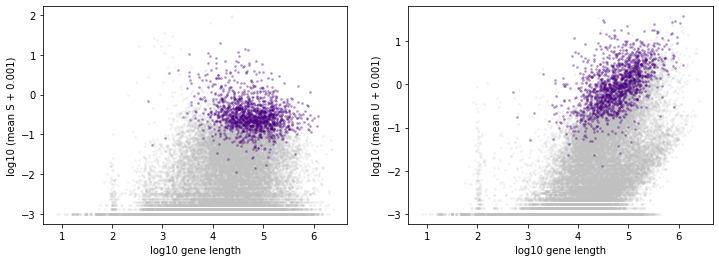

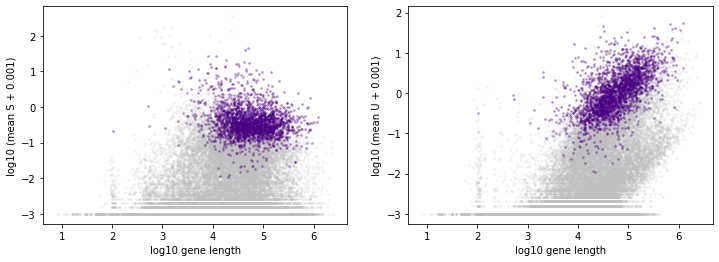

In [72]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='liver_andrews',batch_id=1,\
                                             n_genes=3000,exp_filter_threshold=None,cf=cf)

## Inference

In [ ]:
dir_string

In [ ]:
dataset_strings

Define parameter bounds, then iterate over datasets and perform the fits.

In [74]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-8, -2.5]
samp_ub = [-5, 0]
gridsize = [20,21]

gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1}

INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: liver_c72_sc_CentralHep
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221208_025_liver_andrews_1/genes.csv.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [25:07<00:00,  3.59s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 1510.3 seconds.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: liver_c72_sc_PortalHep
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221208_025_liver_andrews_1/genes.csv.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/raw.sd.
INFO:root:Starting parallelized gri

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [20:31<00:00,  2.93s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 1235.4 seconds.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: liver_c72_sc_InterHep
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221208_025_liver_andrews_1/genes.csv.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/raw.sd.
INFO:root:Starting parallelized grid scan

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [21:24<00:00,  3.06s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 1286.1 seconds.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: liver_c72_sn_CentralHep
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221208_025_liver_andrews_1/genes.csv.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/raw.sd.
INFO:root:Starting parallelized 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:22:07<00:00, 11.73s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 4929.8 seconds.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: liver_c72_sn_PortalHep
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221208_025_liver_andrews_1/genes.csv.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/raw.sd.
INFO:root:Starting parallelized gri

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [39:29<00:00,  5.64s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 2372.4 seconds.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: liver_c72_sn_InterHep
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221208_025_liver_andrews_1/genes.csv.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/raw.sd.
INFO:root:Starting parallelized grid scan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:37:12<00:00, 13.89s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 5834.5 seconds.


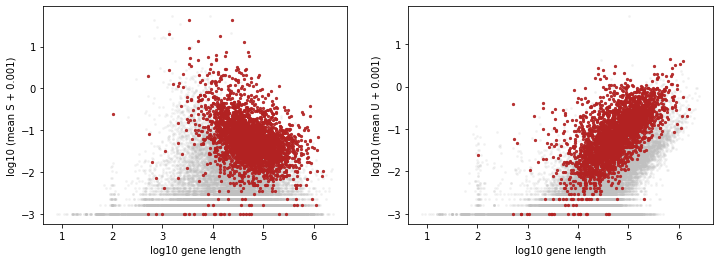

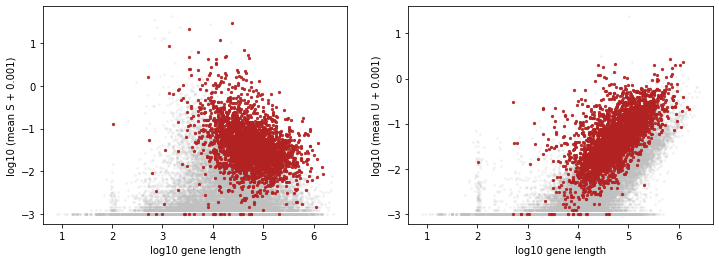

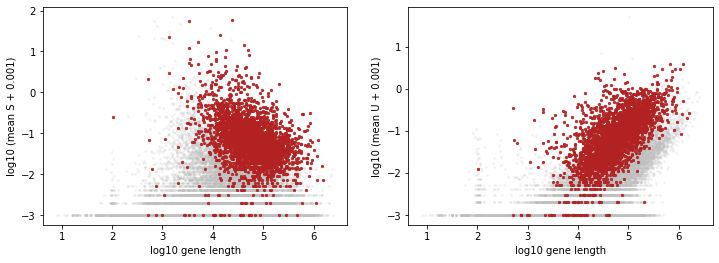

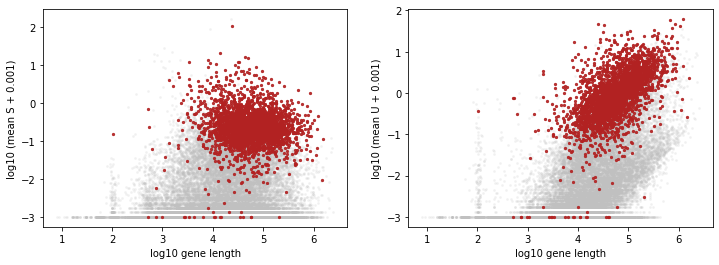

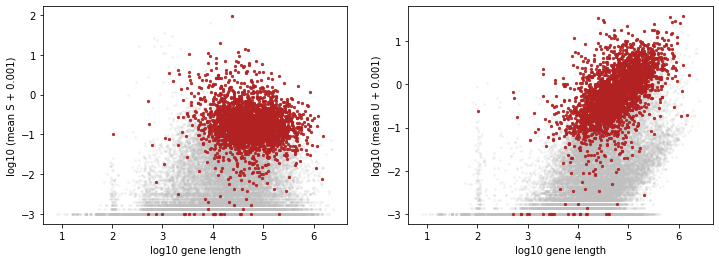

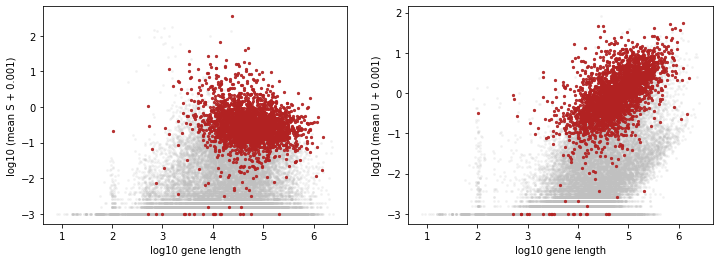

In [75]:
result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = gradient_params)
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(40,search_data)
    result_strings.append(full_result_string)

## Post-processing

INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 164 genes out of 3000. Runtime: 4.8 seconds.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/analysis_figures/subsampling_stability.png.
INFO:root:Or

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square compu

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square comp

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.


/home/ggorin/projects/monod/src/monod/inference.py:1003: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(nrows=1, ncols=num_params, figsize=figsize)


INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 81 genes out of 3000. Runtime: 9.5 seconds.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-squar

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square comp

/home/ggorin/projects/monod/src/monod/inference.py:1370: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221208_025_liver_andrews_1/analysis_figures already exists.


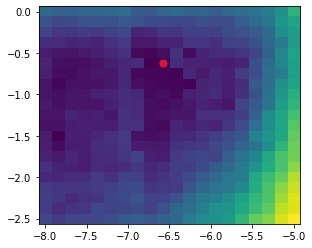

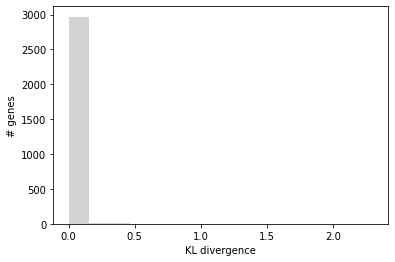

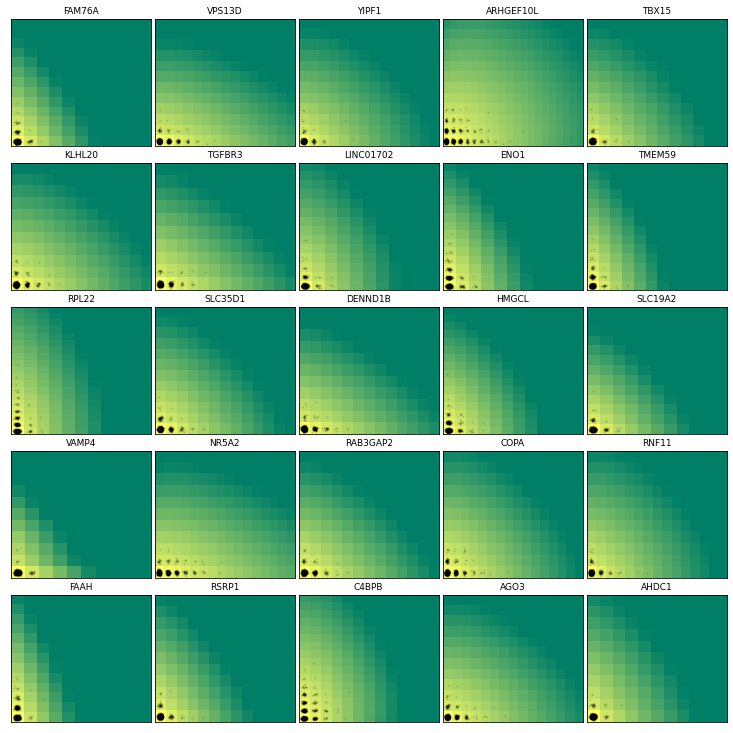

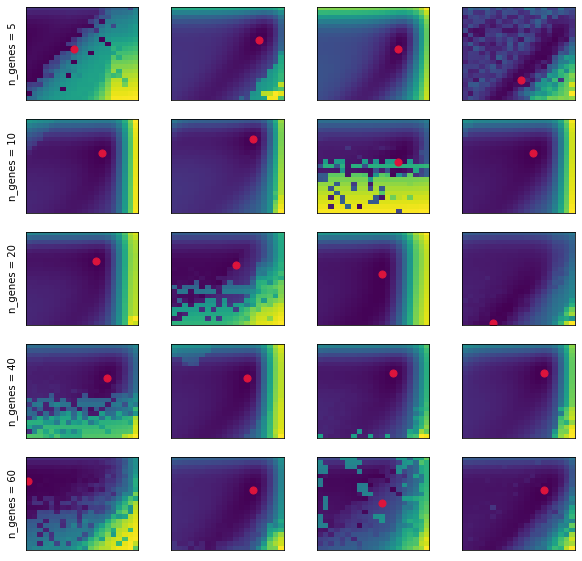

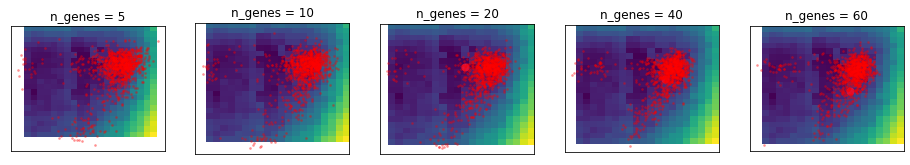

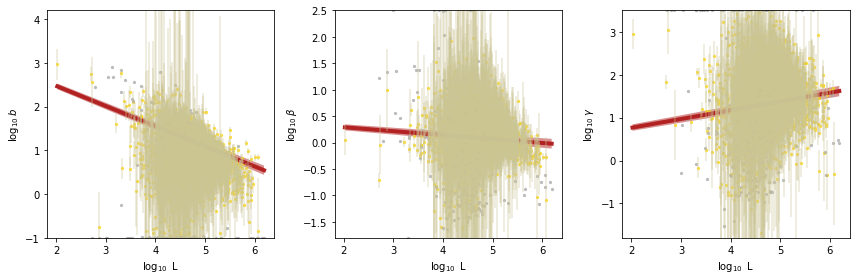

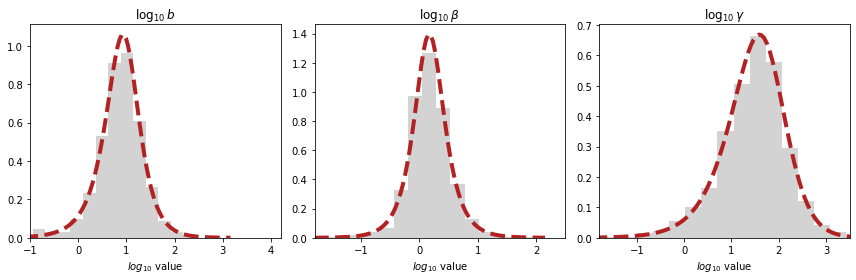

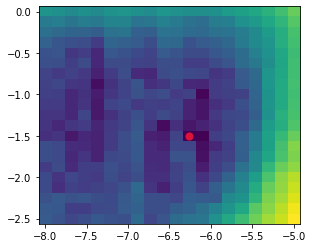

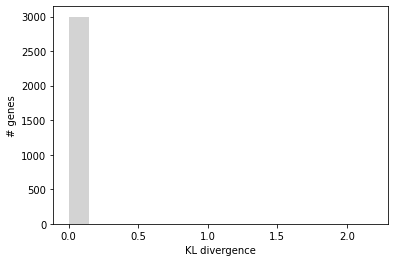

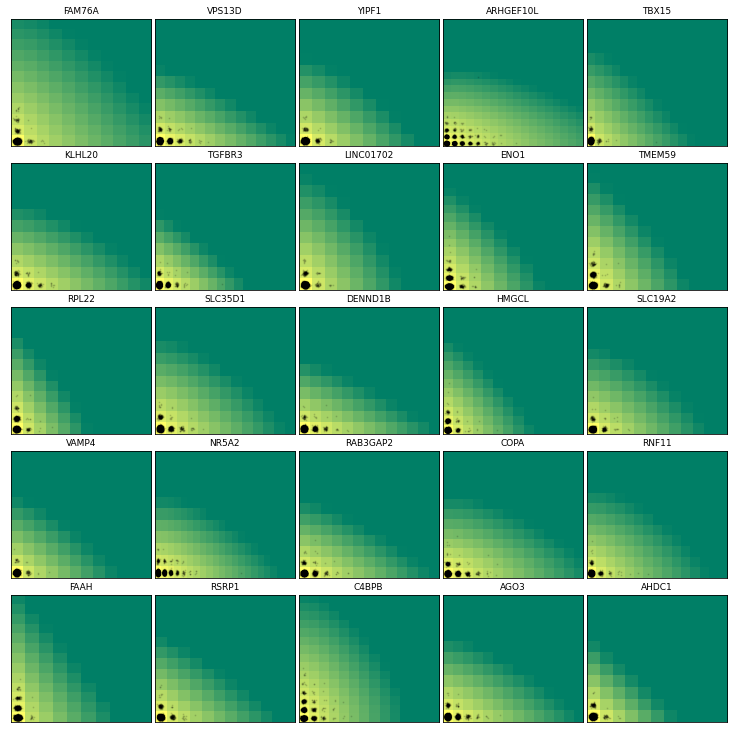

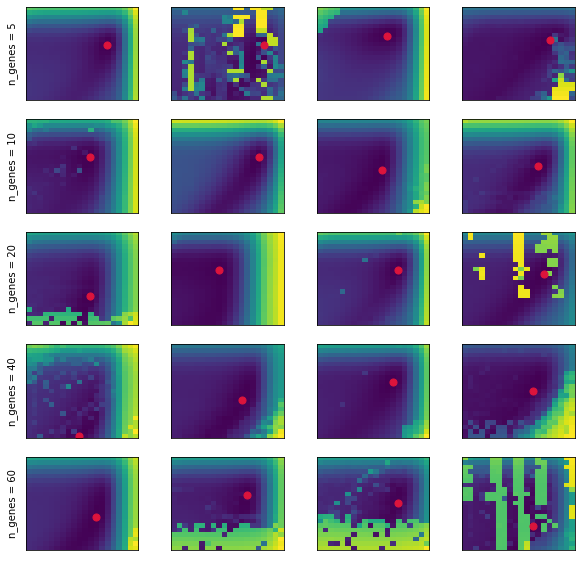

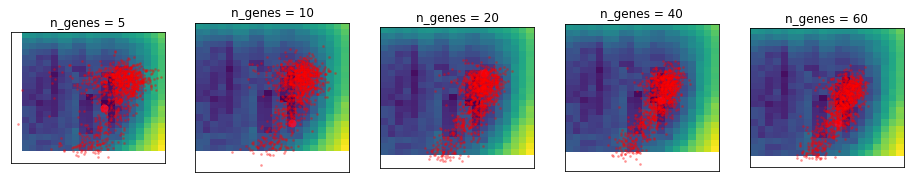

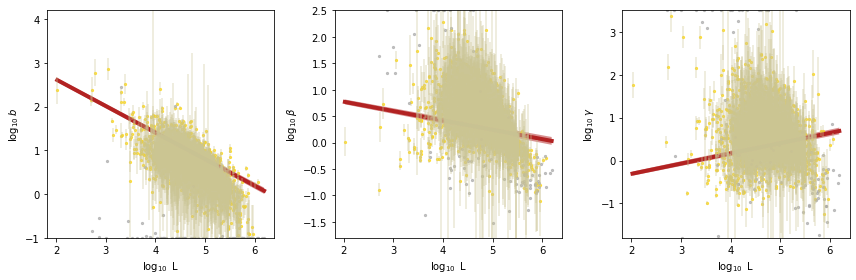

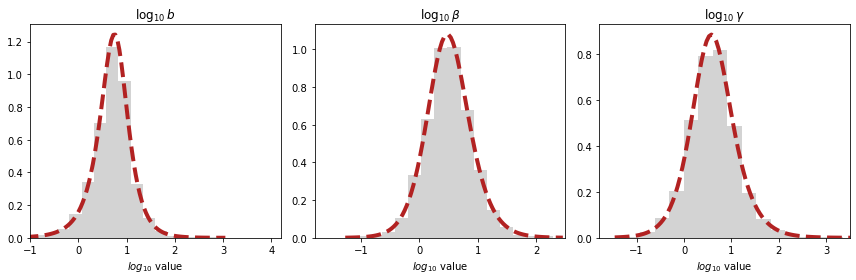

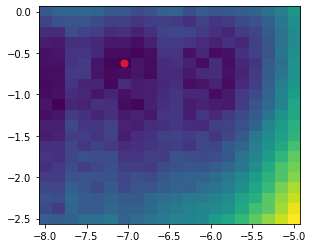

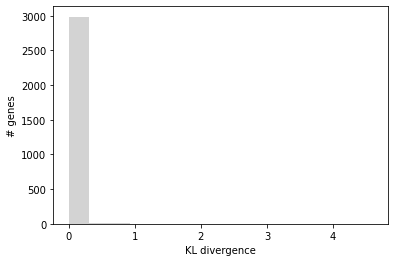

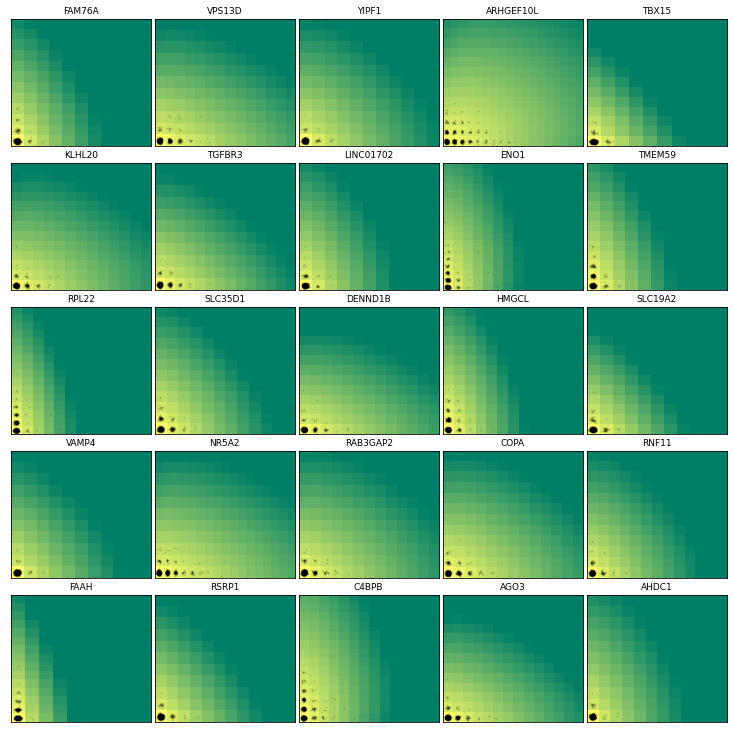

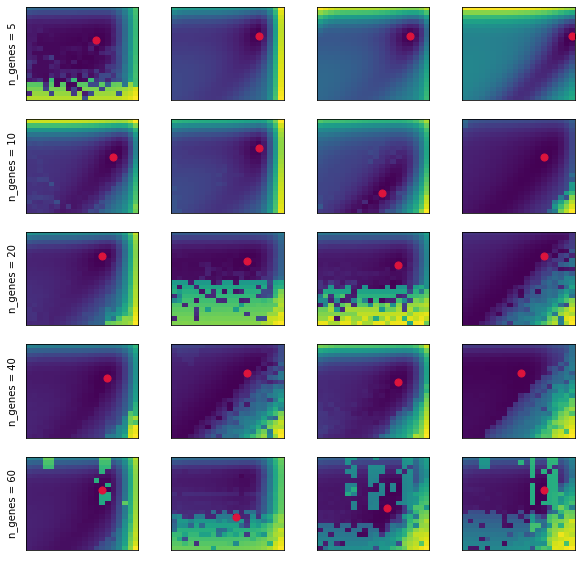

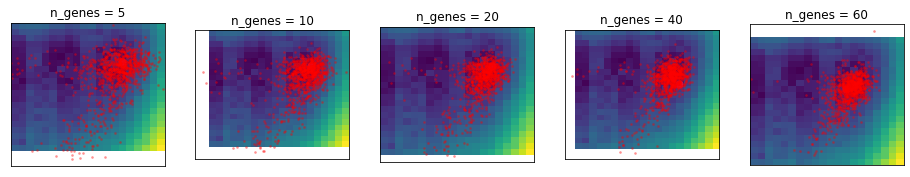

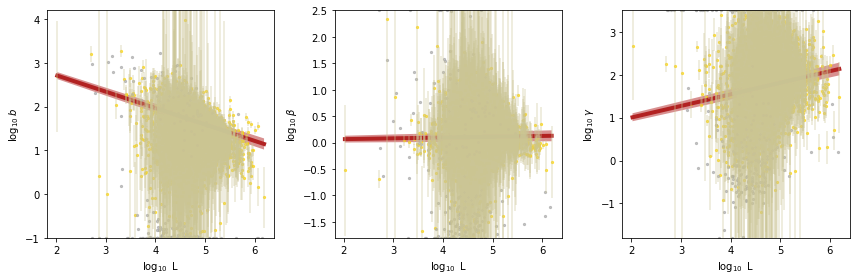

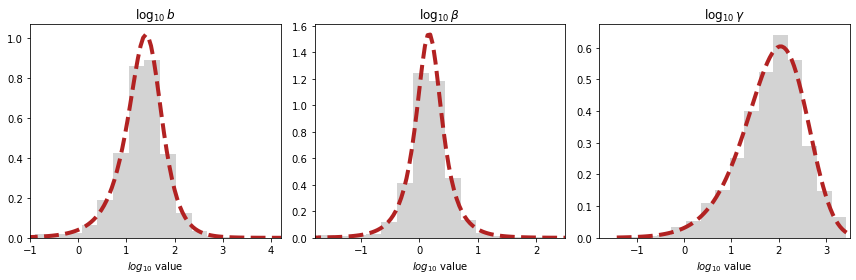

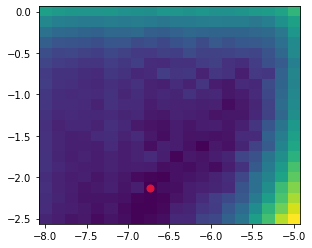

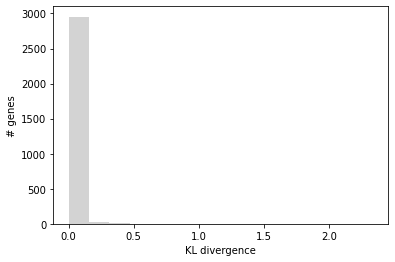

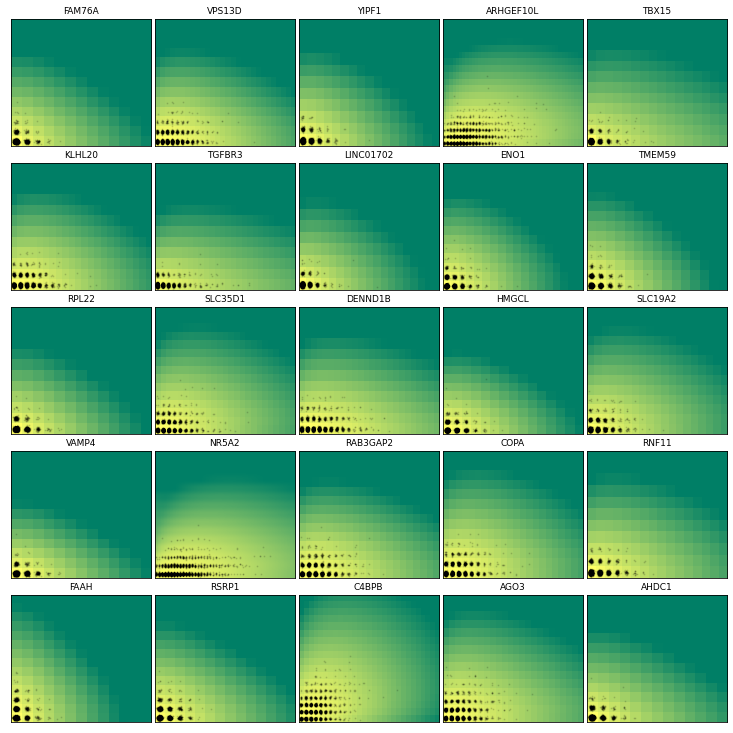

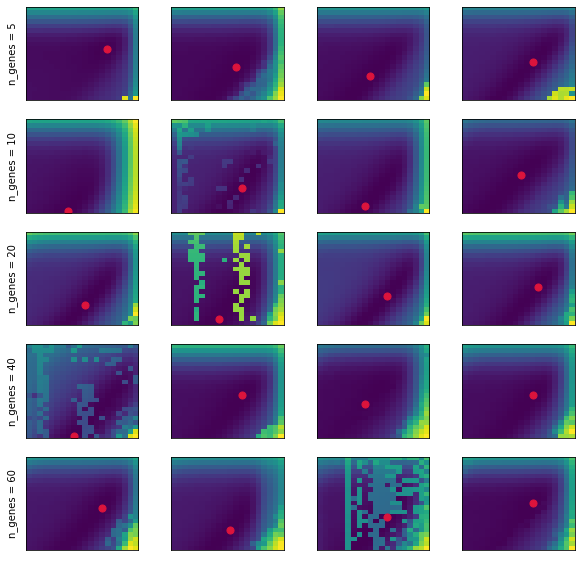

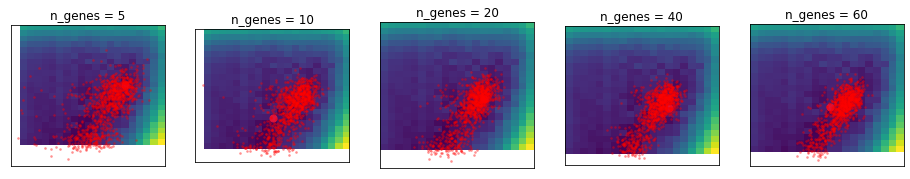

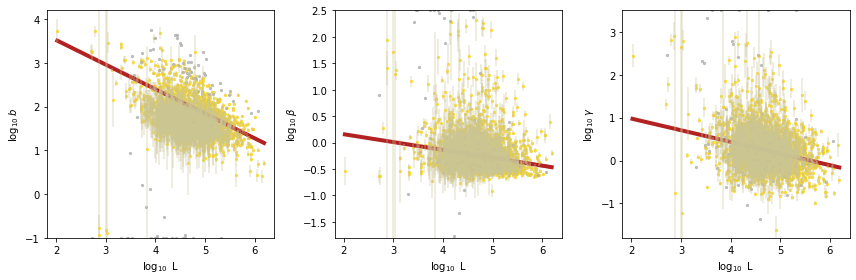

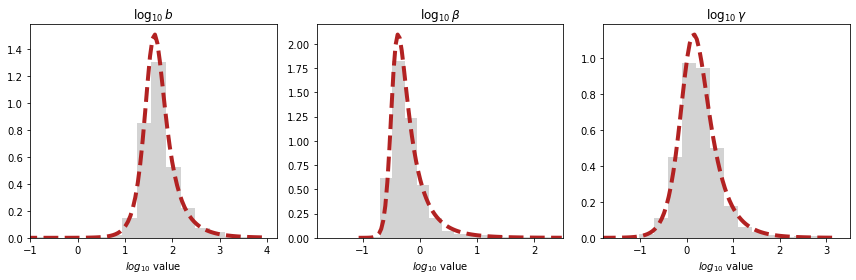

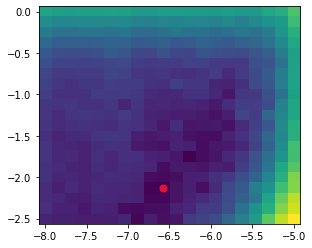

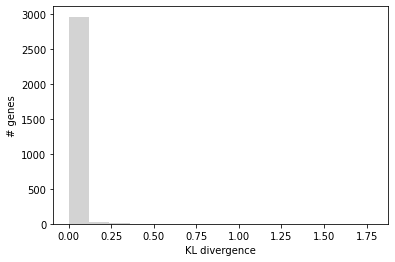

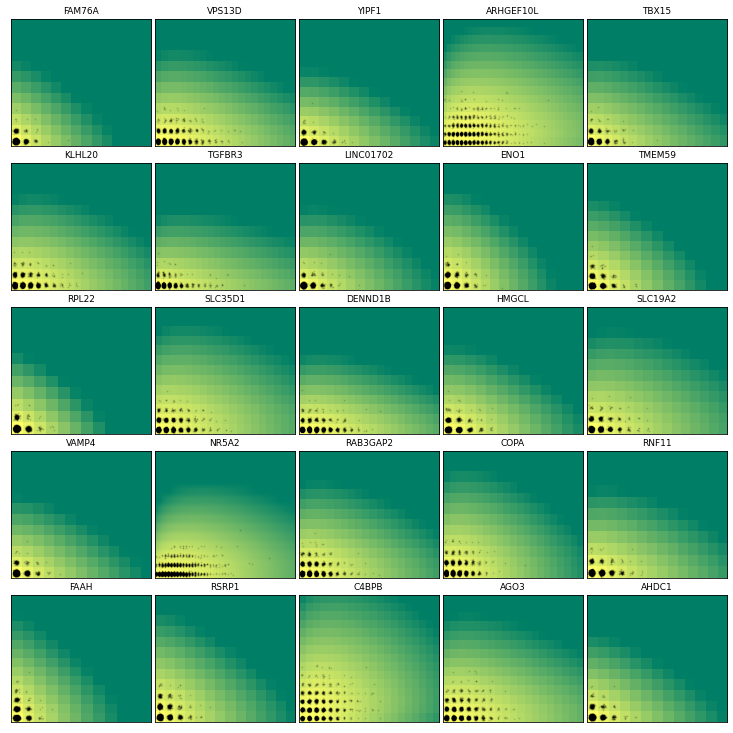

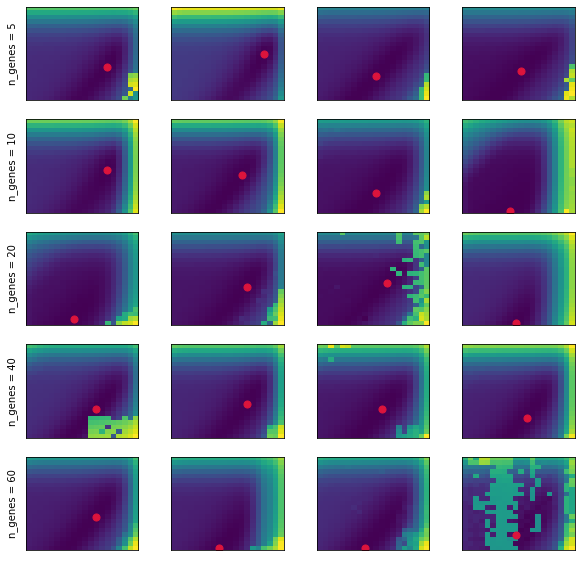

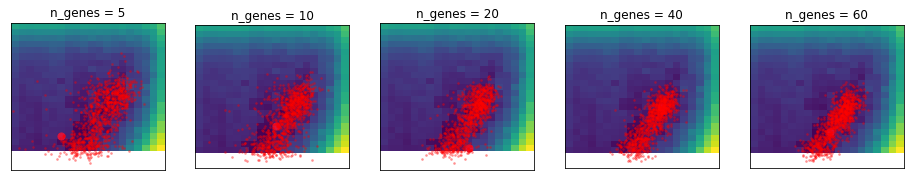

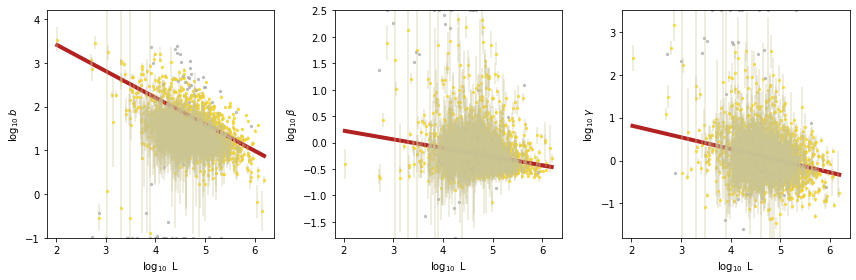

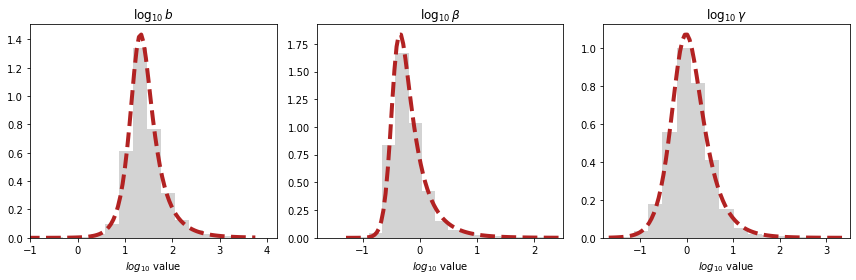

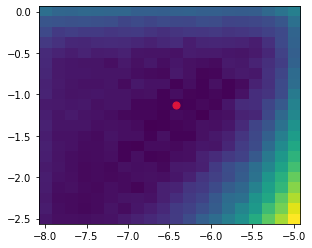

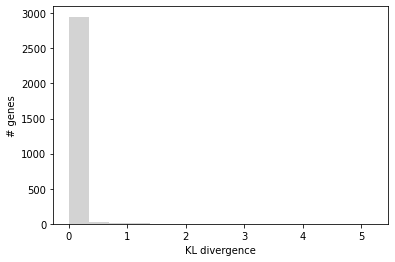

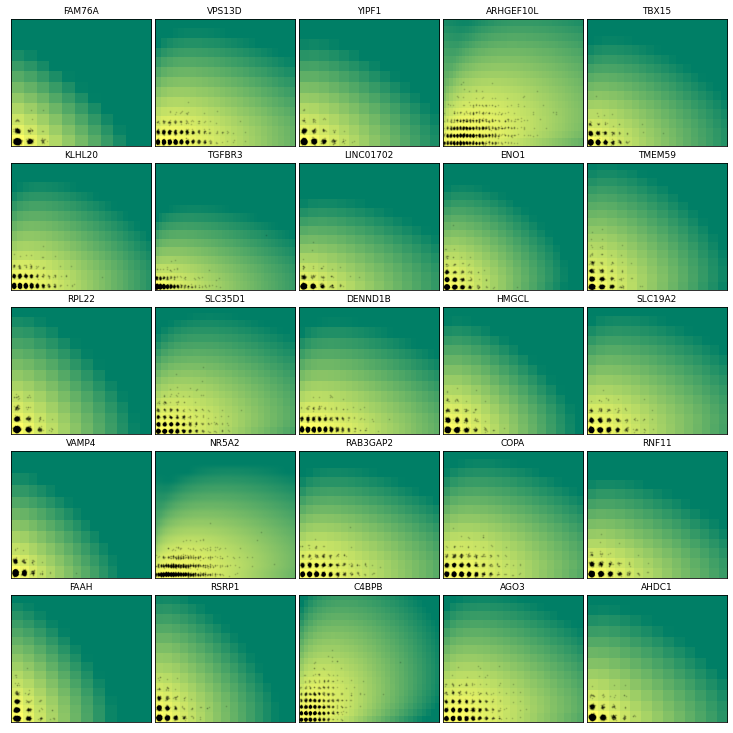

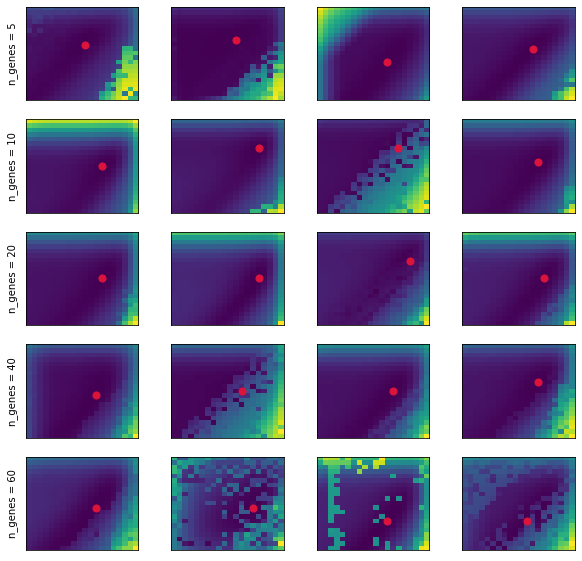

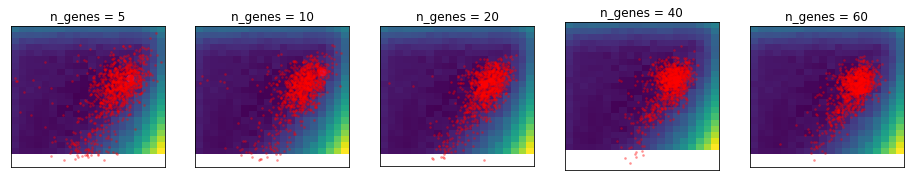

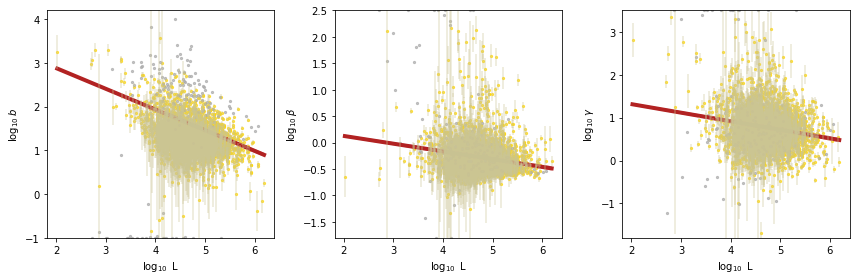

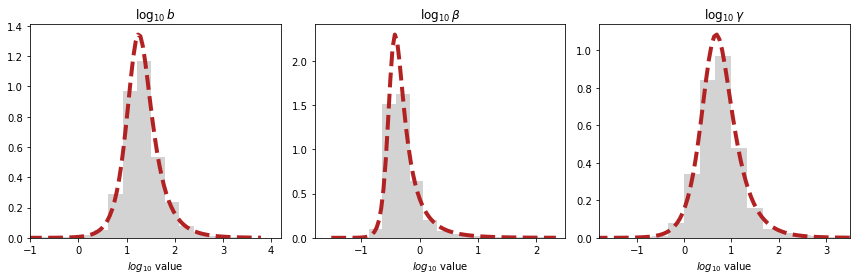

In [76]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

    sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


## Analysis

In [264]:
dir_string = './fits/gg_221208_025_liver_andrews_1'
result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

In [272]:
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]

INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_PortalHep/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_InterHep/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_CentralHep/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_PortalHep/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sn_InterHep/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ./fits/gg_221208_025_liver_andrews_1/liver_c72_sc_CentralHep/raw.sd.
INFO:root

Offset: 0.36
Offset: 1.11


/tmp/ipykernel_436754/1943922227.py:5: RuntimeWarning: invalid value encountered in divide
  stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)


Offset: 0.47
Offset: 1.13
Offset: 0.50
Offset: 1.12


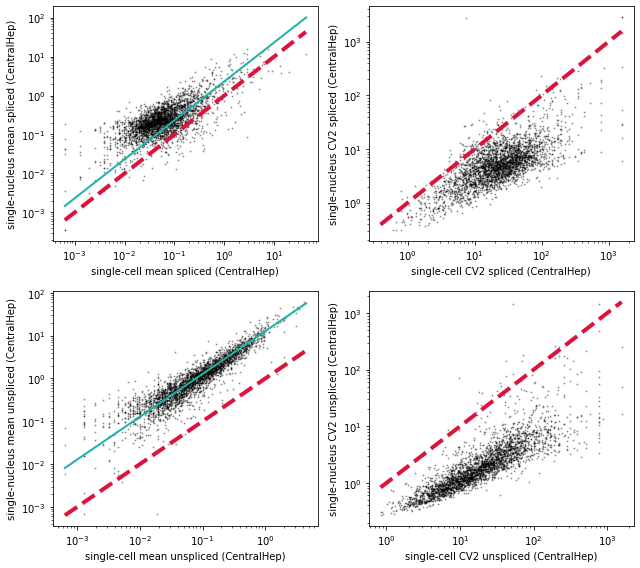

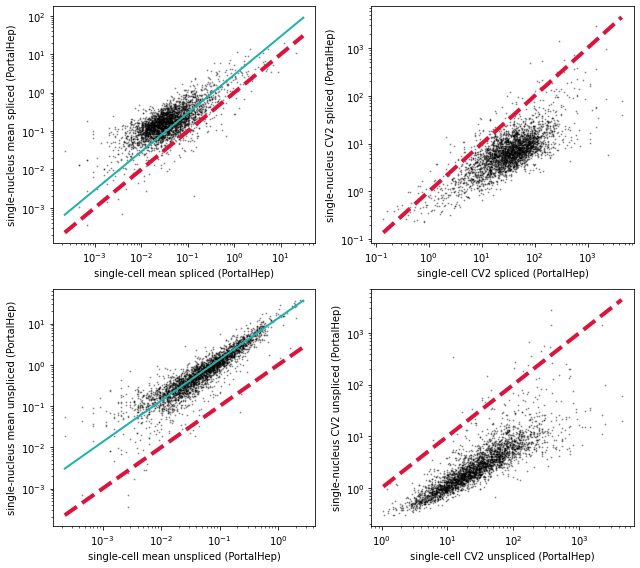

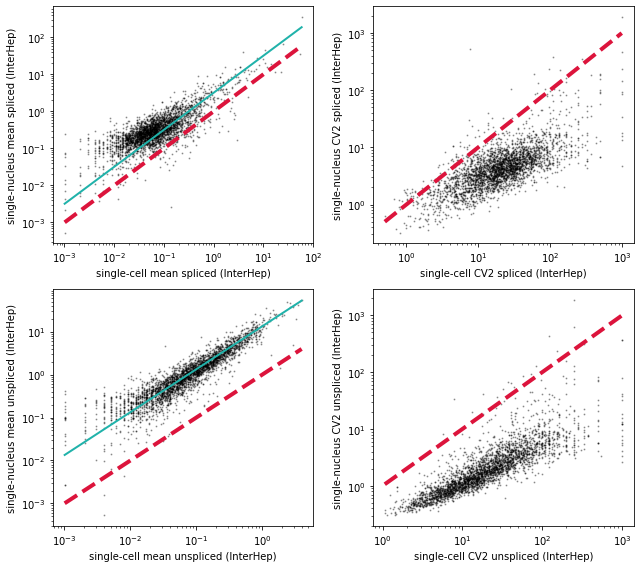

In [200]:
for k in range(3):
    fig1,ax1 = plt.subplots(2,2,figsize=(9,8))
    
    plot_stat(sd_arr[k].layers[1],
              sd_arr[k+3].layers[1],
              'mean',ax1[0][0],'spliced ({})'.format(cluster_names[k]),True)
    plot_stat(sd_arr[k].layers[1],
              sd_arr[k+3].layers[1],
              'CV2',ax1[0][1],'spliced ({})'.format(cluster_names[k]))
    plot_stat(sd_arr[k].layers[0],
              sd_arr[k+3].layers[0],
              'mean',ax1[1][0],'unspliced ({})'.format(cluster_names[k]),True)
    plot_stat(sd_arr[k].layers[0],
              sd_arr[k+3].layers[0],
              'CV2',ax1[1][1],'unspliced ({})'.format(cluster_names[k]))
    fig1.tight_layout()

Single-cell


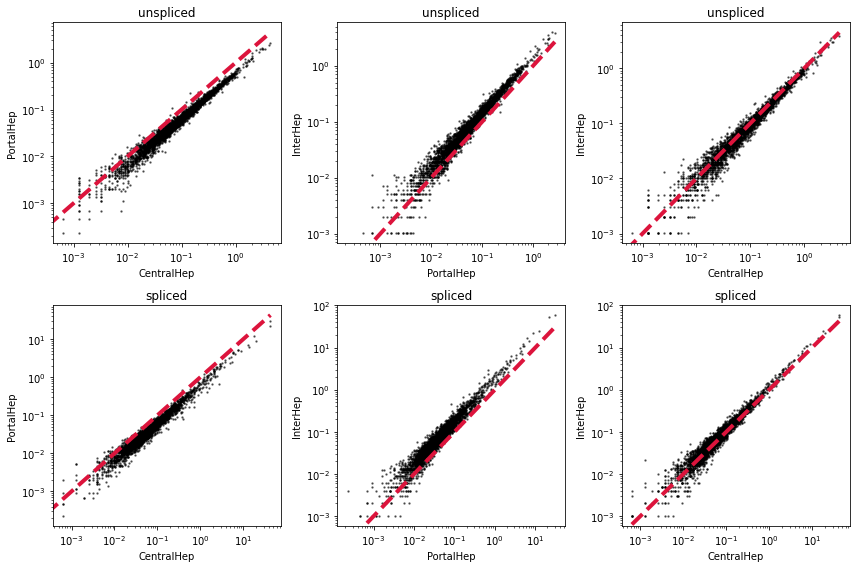

In [201]:
mod_titles = ['unspliced','spliced']
pairs = [[0,1],[1,2],[0,2]]
fig1,ax1 = plt.subplots(2,3,figsize=(12,8))
print('Single-cell')
for k,pair in enumerate(pairs):
    for mod_ in range(2):
        x = sd_arr[pair[0]].layers[mod_].mean(1)
        y = sd_arr[pair[1]].layers[mod_].mean(1)
        ax1[mod_,k].scatter(x,y,2,'k',alpha=0.5)
        ax1[mod_,k].set_xscale('log')
        ax1[mod_,k].set_yscale('log')
        ax1[mod_,k].set_title(mod_titles[mod_])
        ax1[mod_,k].set_xlabel(cluster_names[pair[0]])
        ax1[mod_,k].set_ylabel(cluster_names[pair[1]])
        
        xl = np.linspace(x.min(),x.max())
        ax1[mod_,k].plot(xl,xl,'--',color='crimson',linewidth=4)
fig1.tight_layout()

Single-nucleus


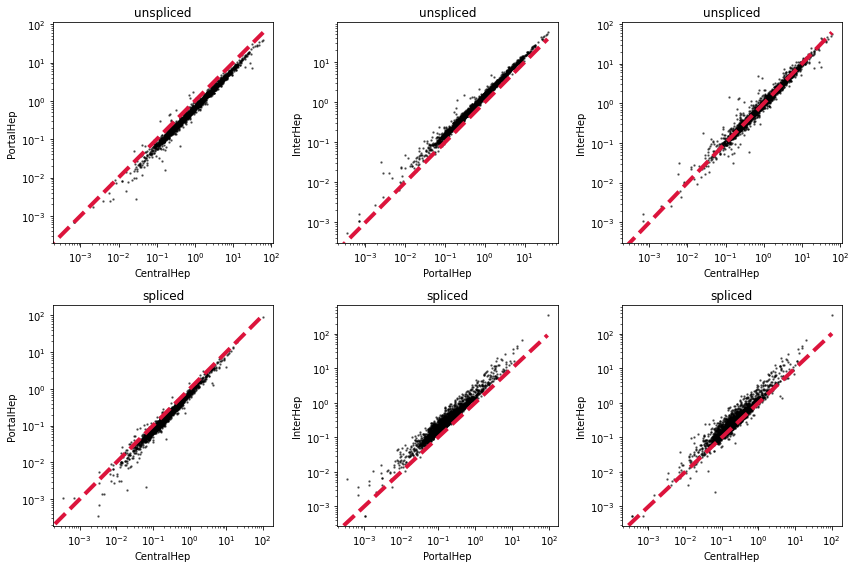

In [202]:
mod_titles = ['unspliced','spliced']
pairs = [[0,1],[1,2],[0,2]]
fig1,ax1 = plt.subplots(2,3,figsize=(12,8))
print('Single-nucleus')
for k,pair in enumerate(pairs):
    for mod_ in range(2):
        x = sd_arr[pair[0]+3].layers[mod_].mean(1)
        y = sd_arr[pair[1]+3].layers[mod_].mean(1)
        ax1[mod_,k].scatter(x,y,2,'k',alpha=0.5)
        ax1[mod_,k].set_xscale('log')
        ax1[mod_,k].set_yscale('log')
        ax1[mod_,k].set_title(mod_titles[mod_])
        ax1[mod_,k].set_xlabel(cluster_names[pair[0]])
        ax1[mod_,k].set_ylabel(cluster_names[pair[1]])
        
        xl = np.linspace(x.min(),x.max())
        ax1[mod_,k].plot(xl,xl,'--',color='crimson',linewidth=4)
fig1.tight_layout()

Single-nucleus vs single-nucleus


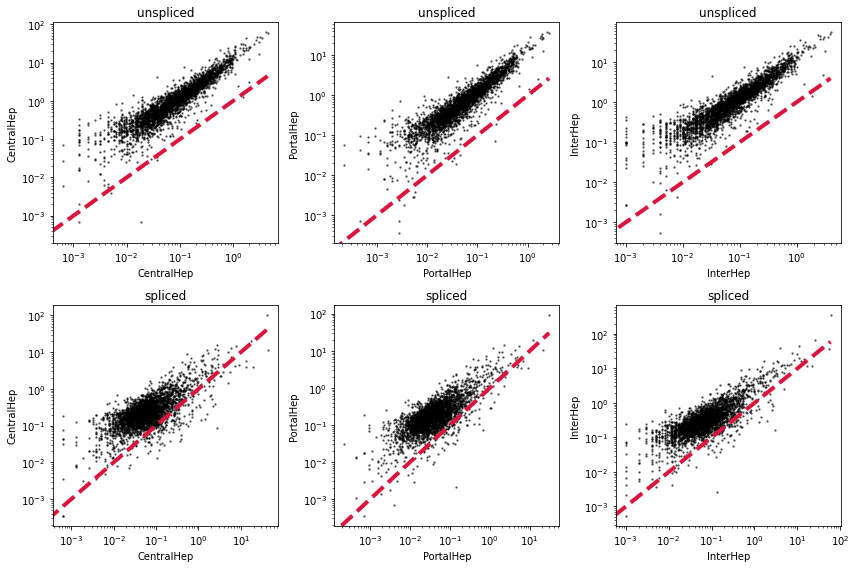

In [203]:
mod_titles = ['unspliced','spliced']
pairs = [[0,0],[1,1],[2,2]]
fig1,ax1 = plt.subplots(2,3,figsize=(12,8))
print('Single-nucleus vs single-nucleus')
for k,pair in enumerate(pairs):
    for mod_ in range(2):
        x = sd_arr[pair[0]].layers[mod_].mean(1)
        y = sd_arr[pair[1]+3].layers[mod_].mean(1)
        ax1[mod_,k].scatter(x,y,2,'k',alpha=0.5)
        ax1[mod_,k].set_xscale('log')
        ax1[mod_,k].set_yscale('log')
        ax1[mod_,k].set_title(mod_titles[mod_])
        ax1[mod_,k].set_xlabel(cluster_names[pair[0]])
        ax1[mod_,k].set_ylabel(cluster_names[pair[1]])
        
        xl = np.linspace(x.min(),x.max())
        ax1[mod_,k].plot(xl,xl,'--',color='crimson',linewidth=4)
fig1.tight_layout()

In [169]:
arbitrary_v2_params = np.asarray([-7,-2])
arbitrary_v2_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v2_params)**2).sum(1))
print(sr_arr[0].sp.sampl_vals[arbitrary_v2_ind])

(-7.052631578947368, -2.0)


In [170]:
samp_lb

[-8, -2.5]

In [171]:
samp_ub

[-5, 0]

sc: -6.58, -1.00
sn: -5.95, -2.50
sc: -6.58, -1.12
sn: -5.95, -2.50
sc: -6.58, -1.12
sn: -5.95, -2.50


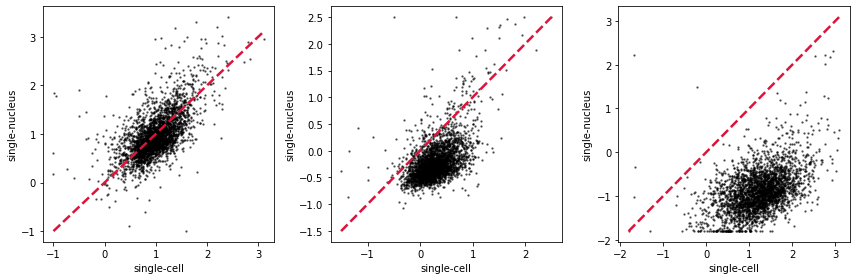

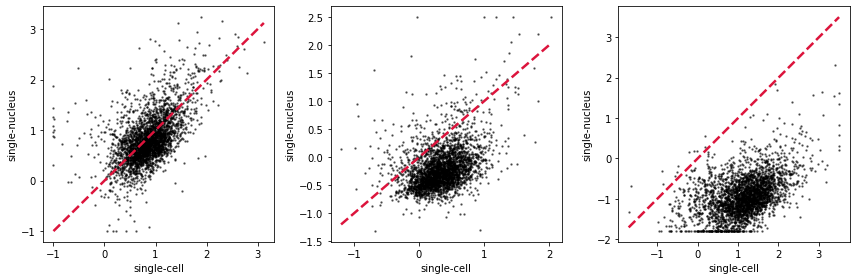

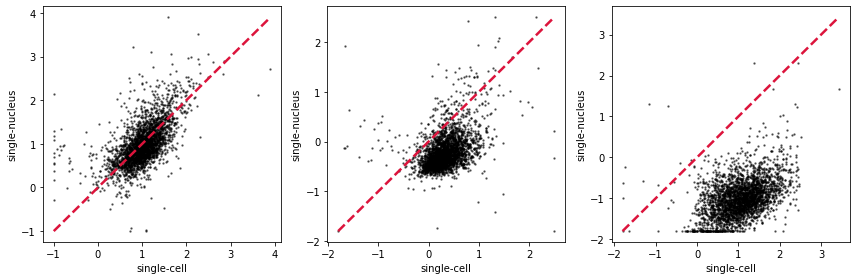

In [403]:
for k in range(3):
    fig1,ax1 = plt.subplots(1,3,figsize=(12,4))

    arbitrary_v3_params = np.asarray([-6,-2.5])
    arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
    sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)

    total_divg = ((sr_arr[k].param_estimates[:,~sr_arr[k+3].rejected_genes,:2] 
                            - sr_arr[k+3].phys_optimum[~sr_arr[k+3].rejected_genes,:2])**2).sum((1,2))

    arbitrary_v2_ind = np.argmin(total_divg)
    sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)
    
    print('sc: {:.2f}, {:.2f}'.format(*sr_arr[k].samp_optimum))

    print('sn: {:.2f}, {:.2f}'.format(*sr_arr[k+3].samp_optimum))
    for j in range(3):
        x = sr_arr[k].phys_optimum[~sr_arr[k].rejected_genes,j]
        y = sr_arr[k+3].phys_optimum[~sr_arr[k].rejected_genes,j]
        ax1[j].scatter(x,y,2,'k',alpha=0.5)
        xl = np.linspace(min(x),max(x))
        ax1[j].plot(xl,xl,'--',color='crimson',linewidth=2.5)
        ax1[j].set_xlabel('single-cell')
        ax1[j].set_ylabel('single-nucleus')
    fig1.tight_layout()

In [253]:
# (np.abs(sr_arr[k+3].param_estimates[:,~sr_arr[k].rejected_genes,1] - sr_arr[k].phys_optimum[~sr_arr[k].rejected_genes,1])).sum(1)

sc: -6.58, -0.62
sn: -6.74, -2.12
sc: -6.26, -1.50
sn: -6.58, -2.12
sc: -7.05, -0.62
sn: -6.42, -1.12


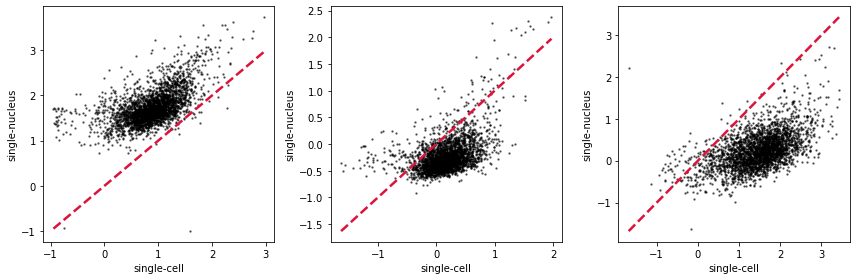

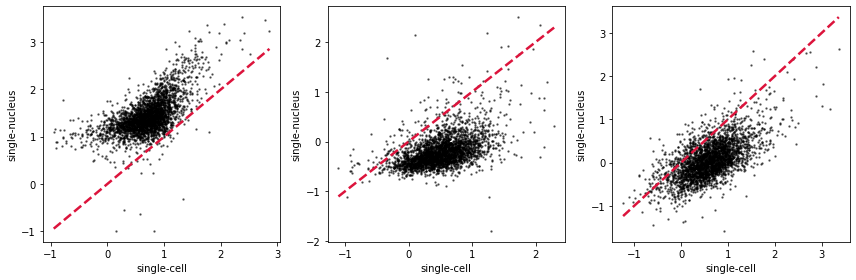

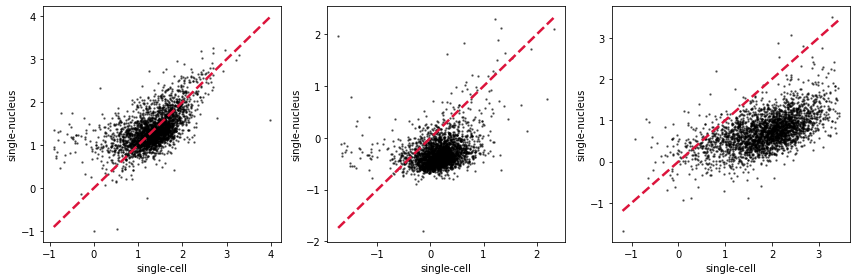

In [213]:
for k in range(3):
    fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
    print('sc: {:.2f}, {:.2f}'.format(*sr_arr[k].samp_optimum))
    print('sn: {:.2f}, {:.2f}'.format(*sr_arr[k+3].samp_optimum))
    for j in range(3):
        x = sr_arr[k].phys_optimum[~sr_arr[k].rejected_genes,j]
        y = sr_arr[k+3].phys_optimum[~sr_arr[k].rejected_genes,j]
        ax1[j].scatter(x,y,2,'k',alpha=0.5)
        xl = np.linspace(min(x),max(x))
        ax1[j].plot(xl,xl,'--',color='crimson',linewidth=2.5)
        ax1[j].set_xlabel('single-cell')
        ax1[j].set_ylabel('single-nucleus')
    fig1.tight_layout()

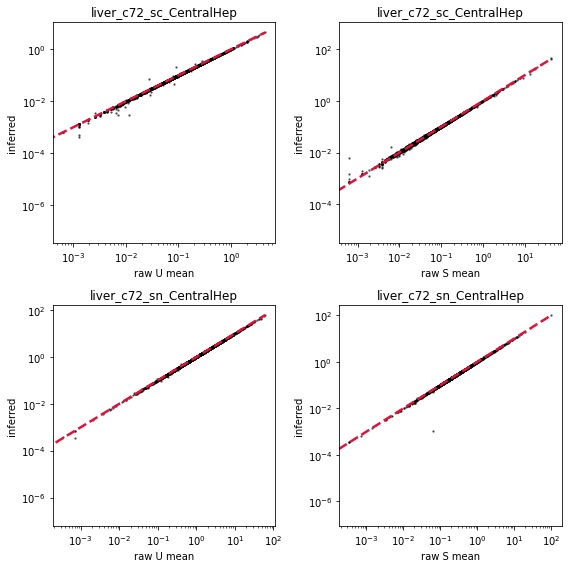

In [273]:
# arbitrary_v3_params = np.asarray([-6.5,0])
# arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
# sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)
fig1,ax1 = plt.subplots(2,2,figsize=(8,8))

k=0
for j in range(2):
    x = sd_arr[k+j*3].layers[0].mean(1)
    y = 10**(sr_arr[k+j*3].regressor_optimum[:,0] + sr_arr[k+j*3].phys_optimum[:,0] - sr_arr[k+j*3].phys_optimum[:,1])
    ax1[j,0].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,0].set_xscale('log')
    ax1[j,0].set_yscale('log')
    ax1[j,0].set_title(dataset_names[k+j*3])
    ax1[j,0].set_xlabel('raw U mean')
    ax1[j,0].set_ylabel('inferred')
    
    x = sd_arr[k+j*3].layers[1].mean(1)
    y = 10**(sr_arr[k+j*3].regressor_optimum[:,1] + sr_arr[k+j*3].phys_optimum[:,0] - sr_arr[k+j*3].phys_optimum[:,2])
    ax1[j,1].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,1].set_xscale('log')
    ax1[j,1].set_yscale('log')
    ax1[j,1].set_title(dataset_names[k+j*3])
    ax1[j,1].set_xlabel('raw S mean')
    ax1[j,1].set_ylabel('inferred')
fig1.tight_layout()

In [443]:
sd_arr

/tmp/ipykernel_436754/938077561.py:18: RuntimeWarning: invalid value encountered in divide
  x = (sd_arr[k+j*3].layers[0].var(1))/(sd_arr[k+j*3].layers[0].mean(1))-1
/tmp/ipykernel_436754/938077561.py:29: RuntimeWarning: invalid value encountered in divide
  x = (sd_arr[k+j*3].layers[1].var(1))/(sd_arr[k+j*3].layers[1].mean(1))-1


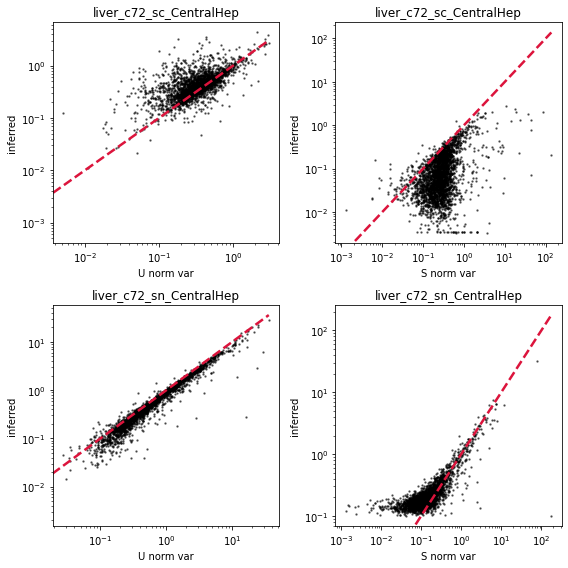

In [447]:
k=0

# arbitrary_v2_params = np.asarray([-8,-2.5])
# arbitrary_v2_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v2_params)**2).sum(1))
# sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)

# arbitrary_v3_params = np.asarray([-6.2,-1.5])
# arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
# sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)

fig1,ax1 = plt.subplots(2,2,figsize=(8,8))

for j in range(2):
    
    physopts = 10**sr_arr[k+j*3].phys_optimum
    sampopts = 10**sr_arr[k+j*3].regressor_optimum
    
    x = (sd_arr[k+j*3].layers[0].var(1))/(sd_arr[k+j*3].layers[0].mean(1))-1
    y = sampopts[:,0] * (1 + physopts[:,0])
    ax1[j,0].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,0].set_xscale('log')
    ax1[j,0].set_yscale('log')
    ax1[j,0].set_title(dataset_names[k+j*3])
    ax1[j,0].set_xlabel('U norm var')
    ax1[j,0].set_ylabel('inferred')
    
    x = (sd_arr[k+j*3].layers[1].var(1))/(sd_arr[k+j*3].layers[1].mean(1))-1
    y = sampopts[:,1] * (1 + physopts[:,0] * physopts[:,1]/(physopts[:,1] + physopts[:,2]))
    ax1[j,1].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,1].set_xscale('log')
    ax1[j,1].set_yscale('log')
    ax1[j,1].set_title(dataset_names[k+j*3])
    ax1[j,1].set_xlabel('S norm var')
    ax1[j,1].set_ylabel('inferred')
fig1.tight_layout()

In [269]:
sr_arr[k+j*3].layers[1].shape

(3000, 2885)

In [271]:
sr_arr[k].samp_optimum

(-6.578947368421053, -0.625)

In [184]:
sr_arr[0].regressor_optimum

array([[-2.48274291, -2.        ],
       [-1.60235475, -2.        ],
       [-2.47193464, -2.        ],
       ...,
       [-1.97226488, -2.        ],
       [-2.35259452, -2.        ],
       [-2.67517962, -2.        ]])

In [189]:
dataset_names

['liver_c72_sc_CentralHep',
 'liver_c72_sc_PortalHep',
 'liver_c72_sc_InterHep',
 'liver_c72_sn_CentralHep',
 'liver_c72_sn_PortalHep',
 'liver_c72_sn_InterHep']

In [223]:
k

0

In [231]:
from matplotlib.colors import ListedColormap
c1 = [0,0,0,0]
# c2 = [1,1,1,1]
c2 = [235/255,228/255,143/255,1]
ncol=2
cmap_highlight_landscape = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)


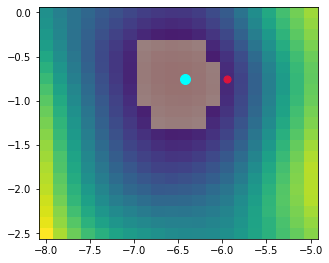

In [395]:
k=2

arbitrary_v3_params = np.asarray([-6,-0.7])
arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)

total_divg = ((sr_arr[k].param_estimates[:,~sr_arr[k+3].rejected_genes,:2] 
                        - sr_arr[k+3].phys_optimum[~sr_arr[k+3].rejected_genes,:2])**2).sum((1,2))

arbitrary_v2_ind = np.argmin(total_divg)
sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)

fig1,ax1=plt.subplots(1,1,figsize=(5,5))
dx = (np.asarray(sr_arr[0].sp.samp_ub) - np.asarray(sr_arr[0].sp.samp_lb)) / (
    np.asarray(sr_arr[0].sp.gridsize) - 1
)
dx[dx < 1e-10] = 0.1
extent = [
    sr_arr[0].sp.samp_lb[0] - dx[0] / 2,
    sr_arr[0].sp.samp_ub[0] + dx[0] / 2,
    sr_arr[0].sp.samp_lb[1] - dx[1] / 2,
    sr_arr[0].sp.samp_ub[1] + dx[1] / 2,
]
lnd = ax1.imshow(
    np.flipud(np.reshape(total_divg, sr_arr[0].sp.gridsize).T), extent=extent
)

q = np.quantile(total_divg,0.1)
lnd = ax1.imshow(
    np.flipud(np.reshape(total_divg>q, sr.sp.gridsize).T), extent=extent,
    cmap = cmap_highlight_landscape,alpha=0.5
)

ax1.scatter(sr_arr[k+3].samp_optimum[0], sr_arr[k+3].samp_optimum[1], c="crimson", s=50)

ax1.scatter(sr_arr[k].samp_optimum[0], sr_arr[k].samp_optimum[1], c="cyan", s=100)

(array([  1.,   0.,   0.,   0.,   2.,   2.,   2.,   4.,   2.,   8.,  14.,
         13.,  36.,  52.,  97., 176., 217., 331., 358., 341., 358., 305.,
        285., 167., 102.,  55.,  39.,  18.,  10.,   5.]),
 array([-4.39986333, -4.26087365, -4.12188397, -3.98289429, -3.84390461,
        -3.70491494, -3.56592526, -3.42693558, -3.2879459 , -3.14895622,
        -3.00996654, -2.87097686, -2.73198718, -2.5929975 , -2.45400782,
        -2.31501814, -2.17602846, -2.03703878, -1.8980491 , -1.75905942,
        -1.62006974, -1.48108006, -1.34209038, -1.2031007 , -1.06411102,
        -0.92512134, -0.78613167, -0.64714199, -0.50815231, -0.36916263,
        -0.23017295]),
 <BarContainer object of 30 artists>)

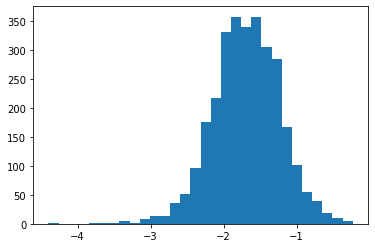

In [396]:
plt.hist(sr_arr[0].regressor_optimum[:,0],30)

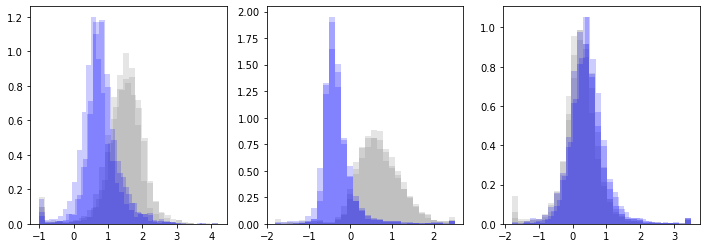

In [454]:

for k in range(3):


    arbitrary_v3_params = np.asarray([-6,-1])
    arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
    sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)

    arbitrary_v2_params = np.asarray([-6.7,-3])
    arbitrary_v2_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v2_params)**2).sum(1))
    sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)

fig1,ax1=plt.subplots(1,3,figsize=(12,4))
colors = ['gray']*3+['b']*3
for j in range(3):
    for k,sr in enumerate(sr_arr):
        ax1[j].hist(sr.phys_optimum[:,j],30,alpha=0.2,color=colors[k],density=True)

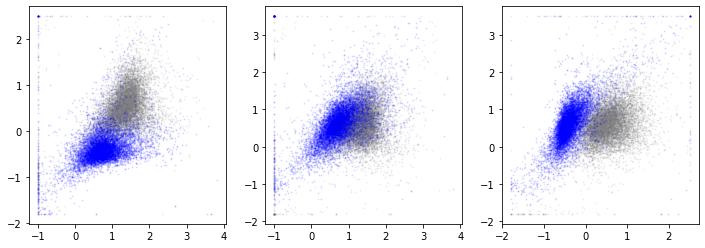

In [452]:
fig1,ax1=plt.subplots(1,3,figsize=(12,4))
colors = ['gray']*3+['b']*3
for j,pair in enumerate([[0,1],[0,2],[1,2]]):
    for k,sr in enumerate(sr_arr):
        ax1[j].scatter(sr.phys_optimum[:,pair[0]],sr.phys_optimum[:,pair[1]],1,alpha=0.1,c=colors[k])

Let's go back and see if I allowed serious issues to slip in BR.

In [299]:
batch_dirs = ['gg_221118_025_pbmc_1','gg_221115_025_heart_1','gg_221116_025_neuron_1','gg_221118_025_allen_1']
 
dataset_v3_list = [['pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B08','C01','F08','H12','B01','A01']]]


In [543]:
batch = 3
k=0
sr = monod.analysis.load_search_results('../../GP_2021_3/notebooks/fits/'+batch_dirs[batch]+'/'+dataset_v3_list[batch][k]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
sd = monod.analysis.load_search_data('../../GP_2021_3/notebooks/fits/'+batch_dirs[batch]+'/'+dataset_v3_list[batch][k]+'/raw.sd')



INFO:root:Grid scan results loaded from ../../GP_2021_3/notebooks/fits/gg_221118_025_allen_1/allen_B08/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ../../GP_2021_3/notebooks/fits/gg_221118_025_allen_1/allen_B08/raw.sd.


In [544]:

physopts  = 10**sr.phys_optimum
sampopts = 10**sr.regressor_optimum

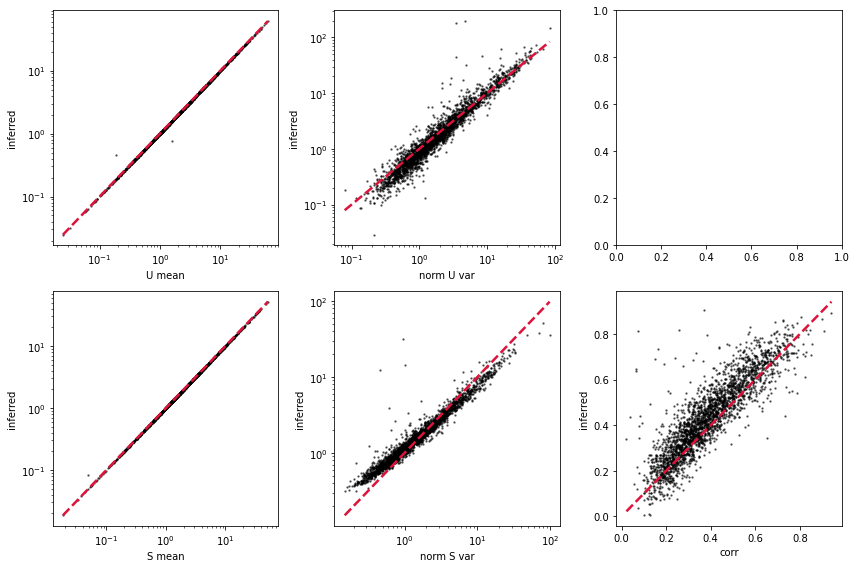

In [551]:

fig1,ax1 = plt.subplots(2,3,figsize=(12,8))


x = sd.layers[0].mean(1)
y = sampopts[:,0] * physopts[:,0]/physopts[:,1]
ax1[0,0].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[0,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[0,0].set_xscale('log')
ax1[0,0].set_yscale('log')
ax1[0,0].set_xlabel('U mean')
ax1[0,0].set_ylabel('inferred')

x = sd.layers[1].mean(1)
y = sampopts[:,1] * physopts[:,0]/physopts[:,2]
ax1[1,0].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[1,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[1,0].set_xscale('log')
ax1[1,0].set_yscale('log')
ax1[1,0].set_xlabel('S mean')
ax1[1,0].set_ylabel('inferred')


x = sd.layers[0].var(1)/sd.layers[0].mean(1) - 1
y = sampopts[:,0] * (1+physopts[:,0])
ax1[0,1].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[0,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[0,1].set_xscale('log')
ax1[0,1].set_yscale('log')
ax1[0,1].set_xlabel('norm U var')
ax1[0,1].set_ylabel('inferred')

F = physopts[:,1]/(physopts[:,1] + physopts[:,2])

x = sd.layers[1].var(1)/sd.layers[1].mean(1) - 1
y = sampopts[:,1] * (1+physopts[:,0] * F)
ax1[1,1].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[1,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[1,1].set_xscale('log')
ax1[1,1].set_yscale('log')
ax1[1,1].set_xlabel('norm S var')
ax1[1,1].set_ylabel('inferred')

x = np.asarray([np.corrcoef(x)[0][1] for x in zip(sd.layers[0],sd.layers[1])])
b = physopts[:,0] 
y = np.sqrt(b**2 * F*(1-F) * sampopts[:,0] * sampopts[:,1] /((1+sampopts[:,0]*(1+b))*(1+sampopts[:,1]*(1+b*F))))
ax1[1,2].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[1,2].plot(xl,xl,'--',color='crimson',linewidth=2.5)
# ax1[1,2].set_xscale('log')
# ax1[1,2].set_yscale('log')
ax1[1,2].set_xlabel('corr')
ax1[1,2].set_ylabel('inferred')
fig1.tight_layout()

Meh. Not so much.

In [519]:

# physopts  = 10**sr.phys_optimum
# sampopts = 10**sr.regressor_optimum

In [466]:
# sr.sp.ph

In [467]:
# physopts = np.asarray([sr.sp.model.get_MoM(x,sr.sp.phys_lb,sr.sp.phys_ub,y) for x,y in zip(sd.moments,sr.regressor_optimum)])
# physopts = 10**physopts

In [520]:
# physopts.shape

In [530]:

# fig1,ax1 = plt.subplots(2,3,figsize=(12,8))


# x = sd.layers[0].mean(1)
# y = sampopts[:,0] * physopts[:,0]/physopts[:,1]
# ax1[0,0].scatter(x,y,2,'k',alpha=0.5)
# xl = np.linspace(min(x),max(x))
# ax1[0,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
# ax1[0,0].set_xscale('log')
# ax1[0,0].set_yscale('log')
# ax1[0,0].set_xlabel('U mean')
# ax1[0,0].set_ylabel('inferred')

# x = sd.layers[1].mean(1)
# y = sampopts[:,1] * physopts[:,0]/physopts[:,2]
# ax1[1,0].scatter(x,y,2,'k',alpha=0.5)
# xl = np.linspace(min(x),max(x))
# ax1[1,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
# ax1[1,0].set_xscale('log')
# ax1[1,0].set_yscale('log')
# ax1[1,0].set_xlabel('S mean')
# ax1[1,0].set_ylabel('inferred')


# x = sd.layers[0].var(1)/sd.layers[0].mean(1) - 1
# y = sampopts[:,0] * (1+physopts[:,0])
# ax1[0,1].scatter(x,y,2,'k',alpha=0.5)
# xl = np.linspace(min(x),max(x))
# ax1[0,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
# ax1[0,1].set_xscale('log')
# ax1[0,1].set_yscale('log')
# ax1[0,1].set_xlabel('norm U var')
# ax1[0,1].set_ylabel('inferred')

# F = physopts[:,1]/(physopts[:,1] + physopts[:,2])

# x = sd.layers[1].var(1)/sd.layers[1].mean(1) - 1
# y = sampopts[:,1] * (1+physopts[:,0] * F)
# ax1[1,1].scatter(x,y,2,'k',alpha=0.5)
# xl = np.linspace(min(x),max(x))
# ax1[1,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
# ax1[1,1].set_xscale('log')
# ax1[1,1].set_yscale('log')
# ax1[1,1].set_xlabel('norm S var')
# ax1[1,1].set_ylabel('inferred')

# x = np.asarray([np.corrcoef(x)[0][1] for x in zip(sd.layers[0],sd.layers[1])])
# b = physopts[:,0] 
# y = np.sqrt(b**2 * F*(1-F) * sampopts[:,0] * sampopts[:,1] /((1+sampopts[:,0]*(1+b))*(1+sampopts[:,1]*(1+b*F))))
# ax1[1,2].scatter(x,y,2,'k',alpha=0.5)
# xl = np.linspace(min(x),max(x))
# ax1[1,2].plot(xl,xl,'--',color='crimson',linewidth=2.5)
# # ax1[1,2].set_xscale('log')
# # ax1[1,2].set_yscale('log')
# ax1[1,2].set_xlabel('corr')
# ax1[1,2].set_ylabel('inferred')
# fig1.tight_layout()

In [550]:
physopts = np.zeros((sr.n_genes,3))
lb = 10**sr.sp.phys_lb
ub = 10**sr.sp.phys_ub
b_S_ = []
b_U_ = []
for k in range(sr.n_genes):
    b_U = (sd.moments[k]["U_var"] / sd.moments[k]["U_mean"] - 1)/ sampopts[k,0] - 1
    gamma_beta = sampopts[k,1] * sd.moments[k]["U_mean"] / (sampopts[k,0] * sd.moments[k]["S_mean"])
    b_S = ((sd.moments[k]["S_var"] / sd.moments[k]["S_mean"] - 1)/ sampopts[k,1] - 1) * (1+gamma_beta)
    b = (b_U+b_S)/2
    b = np.clip(b, lb[0], ub[0])
    
    b_U_.append(b_U)
    b_S_.append(b_S)
    
    physopts[k,0] = b
    
    beta = b*sampopts[k,0]/sd.moments[k]["U_mean"]
    gamma = b*sampopts[k,1]/sd.moments[k]["S_mean"]
    beta = np.clip(beta, lb[1], ub[1])
    gamma = np.clip(gamma, lb[2], ub[2])
    
    physopts[k,1] = beta
    physopts[k,2] = gamma

In [547]:
b_U


329.08523173619767

In [548]:
b_S

213.03000137612102

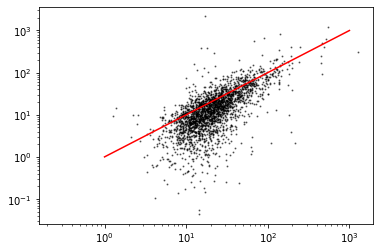

In [534]:
plt.scatter(b_U_,b_S_,1,'k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
xl = [1,1e3]
plt.plot(xl,xl,'r-')

In [496]:
sampopts

array([[0.00409224, 0.23713737],
       [0.08767686, 0.23713737],
       [0.00915612, 0.23713737],
       ...,
       [0.02372911, 0.23713737],
       [0.01000065, 0.23713737],
       [0.01730951, 0.23713737]])

What about cell sizes?

In [554]:
cs = sd.layers[0].sum(0)

In [558]:
cs.shape

(7808,)